In [1]:
pip install transformers==4.28.0

In [2]:
pip install torchmetrics

# Библиотеки

In [3]:
# Визуализации
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
# Общеe
import random
import time
import os
import copy
import pathlib
import numpy as np
import pandas as pd

from tqdm import tqdm

In [5]:
# Модель
import cv2
import torch
from transformers import AutoImageProcessor, TimesformerForVideoClassification
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from transformers import Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup, get_constant_schedule_with_warmup
from torchvision import models, transforms
from torchmetrics import F1Score
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [6]:
from torchvision.io.video import read_video
from torchvision.models.video import r3d_18, R3D_18_Weights
from torchvision.models.video import mvit_v2_s, MViT_V2_S_Weights
from torchvision.models.video import R2Plus1D_18_Weights, r2plus1d_18
from torchvision.models.video import S3D_Weights, s3d

In [7]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/train.zip", 'r')
zip_ref.extractall("/tmp/train")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Модель

In [8]:
model_type = 'torch' # torch / transformers
model_name = 's3d'

In [9]:
if model_type == 'torch':
    if model_name == 'r3d_18':
        weights = R3D_18_Weights.DEFAULT
        model = r3d_18(weights=weights)
        processor = weights.transforms()
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(in_features=num_ftrs, out_features=4)
    if model_name == 'mvit_v2_s':
        weights = MViT_V2_S_Weights.DEFAULT
        model = mvit_v2_s(weights=weights)
        processor = weights.transforms()
        num_ftrs = model.head[1].in_features
        model.head[1] = nn.Linear(in_features=num_ftrs, out_features=4)
    if model_name == 'r2plus1d_18':
        weights = R2Plus1D_18_Weights.DEFAULT
        model = r2plus1d_18(weights=weights)
        processor = weights.transforms()
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(in_features=num_ftrs, out_features=4)
    if model_name == 's3d':
        weights = S3D_Weights.DEFAULT
        model = s3d(weights=weights)
        processor = weights.transforms()
        model.classifier[1] = torch.nn.Conv3d(model.classifier[1].in_channels, 4, kernel_size=model.classifier[1].kernel_size, stride=model.classifier[1].stride)
    n_frames_count = 16 # 16
if model_type == 'transformers':
    if model_name == 'videomae-base-finetuned-kinetics':
        processor = VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")
        model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics",
                                                                num_labels=4,
                                                                ignore_mismatched_sizes=True)
    n_frames_count = 16

# Данные

In [10]:
colab = True
train_size = 0.95
batch_size = 16

In [11]:
DATA_DIR = pathlib.Path("../tmp")
CLASSES = ["bridge_down", "bridge_up", "no_action", "train_in_out"]

clips_data = sum([list(DATA_DIR.joinpath("train", c).glob("*.mp4")) for c in CLASSES], [])
clips_data = pd.DataFrame([clip.parts[-2:] for clip in clips_data], columns=["label", "fname"])

clips_data['label_int'] = 0
class_name_to_int = {'bridge_down': 0, 'bridge_up': 1, 'no_action': 2, 'train_in_out': 3}
clips_data.label_int = clips_data.label.apply(lambda x: class_name_to_int[x])
clips_data.label_int.unique()

array([0, 1, 2, 3])

# Признаки

In [12]:
def read_clip(odir, fname: str, start: int = 0, transposed: bool = True,
              augm=False):
    """Прочесть ролик в массив."""

    cpr = cv2.VideoCapture(odir.joinpath(fname).as_posix())
    has_frame = True
    frames = []

    while has_frame:
        has_frame, frame = cpr.read()
        if has_frame:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            if transposed:
                frame = np.moveaxis(frame, -1, 0).copy()

            frames.append(frame)
    # print(len(frames))
    n_frames = n_frames_count # сколько кадров сохранить с клипа

    if augm:
      if len(frames) > 200:
        n_drop_frames = random.randint(1, 50)
        len_drop_frames = round(50 / n_drop_frames)
        for _ in range(0, n_drop_frames):
            position = random.randint(0, len(frames))
            del frames[position:position + len_drop_frames]
        # print(len(frames))

    if n_frames > len(frames):
      while True:
        frames.append(frames[:-1][0])
        if len(frames) == n_frames:
          break
    else:
        frames = frames[0:len(frames):round(len(frames) / n_frames)]
        if len(frames) == n_frames + 1:
          frames = frames[:-1]
        if len(frames) == n_frames - 1:
          frames.append(frames[:-1][0])
        cpr.release()
    return np.array(frames)[start:]

## аугментация

In [13]:
data_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224)])

In [14]:
data_transforms_1 =transforms.Compose([
            transforms.RandomHorizontalFlip()]) #отображение, ось - вертикаль

data_transforms_2 =transforms.Compose([
            transforms.RandomRotation(degrees=(-20, 20))]) # повороты

data_transforms_3 =transforms.Compose([
            transforms.ColorJitter(brightness=.8, hue=.5)]) # яркость, цвет

data_transforms_4 =transforms.Compose([
            transforms.RandomAutocontrast()]) #контрастность

data_transforms_random = [data_transforms_1, data_transforms_2, data_transforms_3, data_transforms_4]

# рандомная встроенная
data_transforms_random_native = transforms.Compose([
            transforms.RandAugment()])

# авто встроенная
policies = [transforms.AutoAugmentPolicy.CIFAR10, transforms.AutoAugmentPolicy.IMAGENET, transforms.AutoAugmentPolicy.SVHN]
data_transforms_auto_native = transforms.Compose([
            transforms.AutoAugment(policies[1])])

In [15]:
augm_image = True
augm_image_type = 'rand' # rand / 'rand_native' / 'auto_native'
augm_len = True

In [20]:
# 0 - исходное видео
# 1 - augm_image
# 2 - augm_len

In [16]:
x, y = [], []
for index, row in tqdm(clips_data.iterrows()):
    num_mode = random.randint(0, 2)
    # num_mode = 2
    clip = read_clip(DATA_DIR.joinpath("train", row['label']), row['fname'], transposed=True) # клип - несколько изображений
    if num_mode == 0:
      if model_type == 'transformers':
          clip = [torch.Tensor(image) for image in clip]
          inputs = processor(clip, return_tensors="pt")
          x.append(inputs)
      if model_type == 'torch':
          inputs = processor(torch.Tensor(clip)).unsqueeze(0)
          x.append(inputs[0])
      y.append(row['label_int'])
    if augm_len and num_mode == 2:
        clip_new = read_clip(DATA_DIR.joinpath("train", row['label']), row['fname'], transposed=True, augm=True) # клип - несколько изображений
        if model_type == 'torch':
            inputs = processor(torch.Tensor(clip_new)).unsqueeze(0)
            x.append(inputs[0])
        y.append(row['label_int'])
    if augm_image and num_mode == 1: # and index % 3 == 0: # num_mode == 1:
        if augm_image_type == 'rand':
            if model_type == 'torch':
                i = random.randint(0, len(data_transforms_random) - 1)
                clip = np.array([data_transforms_random[i](torch.Tensor(image)).numpy() for image in clip])
                inputs = processor(torch.Tensor(clip)).unsqueeze(0)
                x.append(inputs[0])
                y.append(row['label_int'])
        if augm_image_type in ['rand_native', 'auto_native']:
            if model_type == 'torch':
                i = random.randint(0, len(data_transforms_random) - 1)
                clip_new = []
                for image in clip:
                    img = torch.clip(torch.Tensor(image), 0.0, 255.0)
                    img = img.type(torch.uint8)
                    if augm_image_type == 'rand_native':
                        img_new = data_transforms(data_transforms_random_native(img))
                    elif augm_image_type == 'auto_native':
                        img_new = data_transforms(data_transforms_auto_native(img))
                    clip_new.append(img_new.numpy())
                clip = np.array(clip_new)
                inputs = processor(torch.Tensor(clip)).unsqueeze(0)
                x.append(inputs[0])
                y.append(row['label_int'])

496it [02:34,  3.20it/s]


In [17]:
for x_ in x:
  if x_.shape  != (3, 16, 224, 224):
    print('da')

In [20]:
x = np.array(x)
y = np.array(y)

In [ ]:
if model_type == 'transformers':
  for x_ in x:
    x_['pixel_values'] = x_['pixel_values'][0]
  print(x[0]['pixel_values'].shape)

torch.Size([16, 3, 224, 224])


## сохранение

In [ ]:
import pickle

In [ ]:
with open('x.pkl', 'wb') as f:
  pickle.dump(x, f)

In [ ]:
with open('y.pkl', 'wb') as f:
  pickle.dump(y, f)

In [ ]:
with open('x.pkl', 'rb') as f:
  x = pickle.load(f)
with open('y.pkl', 'rb') as f:
  y = pickle.load(f)

## дисбаланс классов

### если добавлять

In [21]:
y.tolist().count(0), y.tolist().count(1), y.tolist().count(2), y.tolist().count(3)

(306, 75, 49, 66)

In [22]:
balance_under = True
if balance_under:
    k = round((y.tolist().count(0) + y.tolist().count(1) + y.tolist().count(2) + y.tolist().count(3)) / 4)
    # k = max(y.tolist().count(0), y.tolist().count(1), y.tolist().count(2), y.tolist().count(3)) - 1
    print(f'k = {k}')
else:
    k = 0
index_0 = random.choices(np.where(y == 0)[0], k=k) if k > y.tolist().count(0) else np.where(y == 0)[0].tolist()
index_1 = random.choices(np.where(y == 1)[0], k=k) if k > y.tolist().count(1) else np.where(y == 1)[0].tolist()
index_2 = random.choices(np.where(y == 2)[0], k=k) if k > y.tolist().count(2) else np.where(y == 2)[0].tolist()
index_3 = random.choices(np.where(y == 3)[0], k=k) if k > y.tolist().count(3) else np.where(y == 3)[0].tolist()

k = 124


In [23]:
x = np.array(x)[index_0 + index_1 + index_2 + index_3]
y = np.array(y)[index_0 + index_1 + index_2 + index_3]

In [24]:
y.tolist().count(0), y.tolist().count(1), y.tolist().count(2), y.tolist().count(3)

(306, 124, 124, 124)

### если удалять

In [25]:
balance_under = True
if balance_under:
    k = round((y.tolist().count(0) + y.tolist().count(1) + y.tolist().count(2) + y.tolist().count(3)) / 4)
    # k = min(y.count(0), y.count(1), y.count(2), y.count(3))
    print(f'k = {k}')
else:
    k = 15000000
index_0 = random.choices(np.where(y == 0)[0], k=k) if k < y.tolist().count(0) else np.where(y == 0)[0].tolist()
index_1 = random.choices(np.where(y == 1)[0], k=k) if k < y.tolist().count(1) else np.where(y == 1)[0].tolist()
index_2 = random.choices(np.where(y == 2)[0], k=k) if k < y.tolist().count(2) else np.where(y == 2)[0].tolist()
index_3 = random.choices(np.where(y == 3)[0], k=k) if k < y.tolist().count(3) else np.where(y == 3)[0].tolist()

k = 170


In [26]:
x = np.array(x)[index_0 + index_1 + index_2 + index_3]
y = np.array(y)[index_0 + index_1 + index_2 + index_3]

In [27]:
y.tolist().count(0), y.tolist().count(1), y.tolist().count(2), y.tolist().count(3)

(170, 124, 124, 124)

# ClassificationDataset

In [28]:
class ClassificationDataset(torch.utils.data.Dataset):
    """Создание TokenClassificationDataset для дальнейшей передачи его в DataLoader
    """

    def __init__(self, encodings):
        """Инициализация подготовки признаков

        Вход:
            encodings (transformers.tokenization_utils_base.BatchEncoding): BatchEncoding датасета
        """

        self.encodings = encodings

    def __getitem__(self, idx):
        """Вызов по индексу

        Вход:
            idx: индексы
        """

        res = {}
        for key, val in self.encodings.items():
              res[key] = val[idx]
        return res

    def __len__(self):
        """Определение длины
        """
        return len(self.encodings['input'])


In [29]:
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=train_size, stratify=y)

# Модель

In [42]:
momentum = 0.9
num_epochs = 20
output_dir = '/'
optim_name = 'AdamW'
sched_type = 'get_linear_schedule_with_warmup'
learning_rate= 0.0001

## transformer train

In [35]:
device = 'cuda'
model = model.to(device)

In [36]:
training_args = TrainingArguments(
    output_dir='/',
    do_train=True,
    do_eval=True,
    save_strategy='epoch',
    learning_rate=learning_rate,
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

)

In [37]:
image_datasets = {'train': ClassificationDataset({'input_ids': x_train, 'labels': y_train}),
                  'val': ClassificationDataset({'input_ids': x_val, 'labels': x_val}),
                  'test': ClassificationDataset({'input_ids': x, 'labels': y})}

# train_dataset = pd.DataFrame({'input_ids': x_train, 'labels': y_train})
# eval_dataset = pd.DataFrame({'input_ids': x_val, 'labels': x_val})

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=image_datasets['train'],
    eval_dataset=image_datasets['val'],
    # compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

## torch train

In [49]:
image_datasets = {'train': ClassificationDataset({'input': x_train, 'label': y_train}),
                  'val': ClassificationDataset({'input': x_val, 'label': y_val}),
                  'test': ClassificationDataset({'input': x, 'label': y})}

dataloaders = {'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,
                                              shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size,
                                              shuffle=True, num_workers=4),
               'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size,
                                              shuffle=True, num_workers=4)}

In [53]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, batch_size, output_dir):
    """Train the model."""

    # load training/validation data

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'device = {device}')
#     device = 'cpu'
    model = model.to(device)
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f1_total = 0
    log_dir = output_dir
    epoch_loss_train_list, epoch_acc_train_list, epoch_f1_total_train_list, epoch_f1_train_list = [], [], [], []
    epoch_loss_val_list, epoch_acc_val_list, epoch_f1_total_val_list, epoch_f1_val_list = [], [], [], []
    epoch_loss_test_list, epoch_acc_test_list, epoch_f1_total_test_list, epoch_f1_test_list = [], [], [], []

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)

        # Each epoch has a training and validation phase
        if colab:
          phases = ['train', 'val']
        else:
          phases = ['train', 'val', 'test']
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, running_f1_total, running_f1 = [], [], [], []

            # Iterate over data.
            for dataloader in tqdm(dataloaders[phase]):
                time.sleep(0.1)
                inputs = dataloader['input'].to(device)
                labels = dataloader['label'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if model_type == 'transformers':
                        outputs = model(**inputs, labels=labels) # outputs = model(**inputs)
                        _, preds = torch.max(outputs["logits"], 1)
                        loss = outputs["loss"] # loss = criterion(outputs["logits"], labels)
                    if model_type == 'torch':
                        # print(f'inputs.shape = {inputs.shape}')
                        outputs = model(inputs)
                        # print(f'outputs = {outputs.shape}')
                        _, preds = torch.max(outputs, 1)
                        # print(f'preds = {preds}')
                        loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss.append(loss.item()) # running_loss.append(loss.item() * inputs["pixel_values"].size(0))
                running_corrects.append(torch.sum(preds == labels.data))
                if colab:
                    f1_total = F1Score(average='macro', multidim_average='global', num_classes=4, task='multiclass').to(device)
                    f1_total = f1_total(preds, labels).detach().cpu().tolist()
                else:
                    f1_total = functional.f1(preds, labels, average='macro', mdmc_average='global', num_classes=4).detach().cpu().tolist()
                running_f1_total.append(f1_total)
                if colab:
                    f1 = F1Score(average=None, multidim_average='global', num_classes=4, task='multiclass').to(device)
                    f1 = f1(preds, labels).detach().cpu().tolist()
                    f1 = np.array([f1_ if f1_ == f1_ else 0 for f1_ in f1])
                else:
                    f1 = functional.f1(preds, labels, average=None, mdmc_average='global', num_classes=4).detach().cpu().tolist()
                    f1 = np.array([f1_ if f1_ == f1_ else 0 for f1_ in f1])
                running_f1.append(f1)

            epoch_loss = sum(running_loss) / len(running_loss)
            epoch_f1_total = sum(running_f1_total) / len(running_f1_total)
            epoch_f1 = sum(running_f1) / len(running_f1)
            epoch_acc = sum(running_corrects) / len(running_corrects)

            if phase == 'train':
                epoch_loss_train_list.append(epoch_loss)
                epoch_acc_train_list.append(epoch_acc)
                epoch_f1_total_train_list.append(epoch_f1_total)
                epoch_f1_train_list.append(epoch_f1)
            if phase == 'val':
                epoch_loss_val_list.append(epoch_loss)
                epoch_acc_val_list.append(epoch_acc)
                epoch_f1_total_val_list.append(epoch_f1_total)
                epoch_f1_val_list.append(epoch_f1)
            if phase == 'test':
                epoch_loss_test_list.append(epoch_loss)
                epoch_acc_test_list.append(epoch_acc)
                epoch_f1_total_test_list.append(epoch_f1_total)
                epoch_f1_test_list.append(epoch_f1)

            print('{} Loss: {:.4f} Acc: {:.4f} f1_total: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1_total))
            print(f'lr = {scheduler.optimizer.param_groups[0]["lr"]}')

            # deep copy the model
            if phase == 'val' and epoch_f1_total > best_f1_total:
                best_f1_total = epoch_f1_total
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Новая лучшая модель!')
                torch.save(model, f'best.pt')
            torch.save(model, f'epoch_{epoch}.pt')


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    metrics = {'epoch_loss_train_list': epoch_loss_train_list,
          'epoch_acc_train_list': epoch_acc_train_list,
          'epoch_f1_total_train_list': epoch_f1_total_train_list,
          'epoch_f1_train_list': epoch_f1_train_list,

          'epoch_loss_val_list': epoch_loss_val_list,
          'epoch_acc_val_list': epoch_acc_val_list,
          'epoch_f1_total_val_list': epoch_f1_total_val_list,
          'epoch_f1_val_list': epoch_f1_val_list,

          'epoch_loss_test_list': epoch_loss_test_list,
          'epoch_acc_test_list': epoch_acc_test_list,
          'epoch_f1_total_test_list': epoch_f1_total_test_list,
          'epoch_f1_test_list': epoch_f1_test_list,}

    return model, metrics

In [54]:
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
if optim_name == 'SGD':
  optimizer_ft = optim.SGD(model.parameters(),
                            lr=learning_rate, momentum=momentum)
if optim_name == 'AdamW':
  optimizer_ft = optim.AdamW(model.parameters(),
                            lr=learning_rate)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_ft, step_size=5, gamma=0.1)

num_steps = round(len(image_datasets['train']) / batch_size) * num_epochs
print(f'num_steps = {num_steps}')

if sched_type == 'get_linear_schedule_with_warmup':
  exp_lr_scheduler = get_linear_schedule_with_warmup(
      optimizer_ft, round(num_steps * 0.2), num_steps)
if sched_type == 'get_constant_schedule_with_warmup':
  exp_lr_scheduler = get_constant_schedule_with_warmup(
      optimizer_ft, round(num_steps * 0.2))
      # exp_lr_scheduler = lr_scheduler.StepLR(
      #     optimizer_ft, step_size=2, gamma=0.1)

num_steps = 640


In [55]:
model, metrics = train_model(model, criterion, optimizer_ft,
                    exp_lr_scheduler, num_epochs, dataloaders, batch_size, output_dir)

device = cuda


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0/19
--------------------



100%|██████████| 33/33 [00:43<00:00,  1.31s/it]


train Loss: 1.3225 Acc: 5.9091 f1_total: 0.2886
lr = 2.578125e-05



100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


val Loss: 1.5338 Acc: 2.0000 f1_total: 0.0587
lr = 2.578125e-05
Новая лучшая модель!


  5%|▌         | 1/20 [00:45<14:23, 45.45s/it]


Epoch 1/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.28s/it]


train Loss: 0.9232 Acc: 11.6970 f1_total: 0.7156
lr = 5.15625e-05



100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


val Loss: 1.4742 Acc: 3.0000 f1_total: 0.0882
lr = 5.15625e-05
Новая лучшая модель!


 10%|█         | 2/20 [01:29<13:25, 44.76s/it]


Epoch 2/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.30s/it]


train Loss: 0.5094 Acc: 14.1212 f1_total: 0.8808
lr = 7.734375e-05



100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


val Loss: 1.3426 Acc: 4.0000 f1_total: 0.1823
lr = 7.734375e-05
Новая лучшая модель!


 15%|█▌        | 3/20 [02:14<12:42, 44.87s/it]


Epoch 3/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.2947 Acc: 14.5455 f1_total: 0.8956
lr = 9.921875000000001e-05



100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


val Loss: 1.0763 Acc: 7.0000 f1_total: 0.3635
lr = 9.921875000000001e-05
Новая лучшая модель!


 20%|██        | 4/20 [02:59<11:57, 44.83s/it]


Epoch 4/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.1872 Acc: 14.6667 f1_total: 0.9306
lr = 9.27734375e-05



100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


val Loss: 0.8371 Acc: 8.5000 f1_total: 0.5339
lr = 9.27734375e-05
Новая лучшая модель!


 25%|██▌       | 5/20 [03:44<11:11, 44.76s/it]


Epoch 5/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.1658 Acc: 14.7576 f1_total: 0.9266
lr = 8.6328125e-05



100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


val Loss: 0.6531 Acc: 12.0000 f1_total: 0.8109
lr = 8.6328125e-05
Новая лучшая модель!


 30%|███       | 6/20 [04:28<10:25, 44.69s/it]


Epoch 6/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.1737 Acc: 14.7576 f1_total: 0.9121
lr = 7.98828125e-05



 35%|███▌      | 7/20 [05:13<09:39, 44.61s/it]

val Loss: 0.6317 Acc: 11.5000 f1_total: 0.7930
lr = 7.98828125e-05

Epoch 7/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.1402 Acc: 14.7273 f1_total: 0.9358
lr = 7.34375e-05



 40%|████      | 8/20 [05:57<08:54, 44.56s/it]

val Loss: 0.5831 Acc: 11.5000 f1_total: 0.8009
lr = 7.34375e-05

Epoch 8/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.1338 Acc: 14.6364 f1_total: 0.9236
lr = 6.699218750000001e-05



 45%|████▌     | 9/20 [06:42<08:10, 44.60s/it]

val Loss: 0.4898 Acc: 11.5000 f1_total: 0.7345
lr = 6.699218750000001e-05

Epoch 9/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.1672 Acc: 14.6970 f1_total: 0.9109
lr = 6.0546875e-05



 50%|█████     | 10/20 [07:26<07:25, 44.55s/it]

val Loss: 0.3798 Acc: 12.0000 f1_total: 0.7629
lr = 6.0546875e-05

Epoch 10/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.1897 Acc: 14.5758 f1_total: 0.8976
lr = 5.4101562500000005e-05



100%|██████████| 2/2 [00:01<00:00,  1.21it/s]


val Loss: 0.3169 Acc: 12.5000 f1_total: 0.8847
lr = 5.4101562500000005e-05
Новая лучшая модель!


 55%|█████▌    | 11/20 [08:11<06:41, 44.60s/it]


Epoch 11/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.1377 Acc: 14.7576 f1_total: 0.9249
lr = 4.765625e-05



 60%|██████    | 12/20 [08:55<05:56, 44.57s/it]

val Loss: 0.4717 Acc: 12.0000 f1_total: 0.7308
lr = 4.765625e-05

Epoch 12/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.1714 Acc: 14.8485 f1_total: 0.9119
lr = 4.12109375e-05



 65%|██████▌   | 13/20 [09:40<05:11, 44.53s/it]

val Loss: 0.4181 Acc: 12.0000 f1_total: 0.8443
lr = 4.12109375e-05

Epoch 13/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.1315 Acc: 14.7879 f1_total: 0.9306
lr = 3.4765625e-05



 70%|███████   | 14/20 [10:24<04:27, 44.55s/it]

val Loss: 0.3648 Acc: 12.5000 f1_total: 0.8696
lr = 3.4765625e-05

Epoch 14/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.1145 Acc: 14.9394 f1_total: 0.9400
lr = 2.83203125e-05



 75%|███████▌  | 15/20 [11:09<03:42, 44.56s/it]

val Loss: 0.2558 Acc: 12.5000 f1_total: 0.8696
lr = 2.83203125e-05

Epoch 15/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.1007 Acc: 14.8788 f1_total: 0.9406
lr = 2.1875e-05



 80%|████████  | 16/20 [11:54<02:58, 44.57s/it]

val Loss: 0.2086 Acc: 12.5000 f1_total: 0.8734
lr = 2.1875e-05

Epoch 16/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.1074 Acc: 14.9697 f1_total: 0.9534
lr = 1.54296875e-05



 85%|████████▌ | 17/20 [12:38<02:13, 44.54s/it]

val Loss: 0.1949 Acc: 12.5000 f1_total: 0.8745
lr = 1.54296875e-05

Epoch 17/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.30s/it]


train Loss: 0.1015 Acc: 15.0606 f1_total: 0.9593
lr = 8.984375e-06



100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


val Loss: 0.1505 Acc: 12.5000 f1_total: 0.9009
lr = 8.984375e-06
Новая лучшая модель!


 90%|█████████ | 18/20 [13:23<01:29, 44.67s/it]


Epoch 18/19
--------------------



100%|██████████| 33/33 [00:42<00:00,  1.29s/it]


train Loss: 0.0907 Acc: 14.9697 f1_total: 0.9488
lr = 2.5390625000000003e-06



100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


val Loss: 0.1349 Acc: 13.5000 f1_total: 0.9444
lr = 2.5390625000000003e-06
Новая лучшая модель!


 95%|█████████▌| 19/20 [14:08<00:44, 44.71s/it]


Epoch 19/19
--------------------



100%|██████████| 33/33 [00:43<00:00,  1.33s/it]


train Loss: 0.1408 Acc: 15.0000 f1_total: 0.9362
lr = 0.0



100%|██████████| 20/20 [14:54<00:00, 44.70s/it]

val Loss: 0.1267 Acc: 13.0000 f1_total: 0.9087
lr = 0.0

Training complete in 14m 54s
Best val Acc: 0.000000


In [56]:
torch.cuda.empty_cache()

# Графики

In [57]:
metrics['epoch_f1_total_val_list']

[0.05870445258915424,
 0.08823529724031687,
 0.18225108459591866,
 0.3635416701436043,
 0.5339285731315613,
 0.8108585774898529,
 0.7929924130439758,
 0.8008928894996643,
 0.7344697117805481,
 0.7629419267177582,
 0.8847222328186035,
 0.7307539582252502,
 0.8442911505699158,
 0.8695887923240662,
 0.8695887625217438,
 0.873391717672348,
 0.8745039701461792,
 0.9008928537368774,
 0.9444444477558136,
 0.908730149269104]

In [58]:
epoch_f1_total_train_list = metrics['epoch_f1_total_train_list']
epoch_f1_total_val_list = metrics['epoch_f1_total_val_list']
epoch_f1_total_test_list = metrics['epoch_f1_total_test_list']

In [70]:
# максимальное значение метрики на валидации
best_epoch = np.argmax(epoch_f1_total_val_list)
best_f1_total = np.max(epoch_f1_total_val_list)
best_f1_total

0.9444444477558136

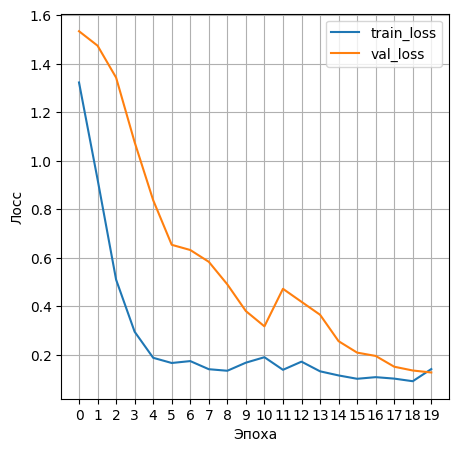

In [79]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(0, num_epochs), metrics['epoch_loss_train_list'], label='train_loss')
plt.plot(np.arange(0, num_epochs), metrics['epoch_loss_val_list'], label='val_loss')
# plt.plot(np.arange(0, num_epochs), metrics['epoch_loss_test_list'], label='test_loss')
plt.xticks(np.arange(0, num_epochs, 1))
plt.xlabel('Эпоха')
plt.ylabel('Лосс')
plt.grid()
plt.legend()
plt.show()

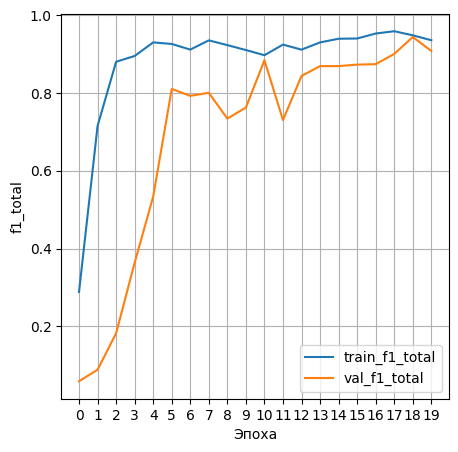

In [80]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(0, num_epochs), epoch_f1_total_train_list, label='train_f1_total')
plt.plot(np.arange(0, num_epochs), epoch_f1_total_val_list, label='val_f1_total')
# plt.plot(np.arange(0, num_epochs), epoch_f1_total_test_list, label='test_f1_total')
plt.xticks(np.arange(0, num_epochs, 1))
plt.xlabel('Эпоха')
plt.ylabel('f1_total')
plt.grid()
plt.legend()
plt.show()

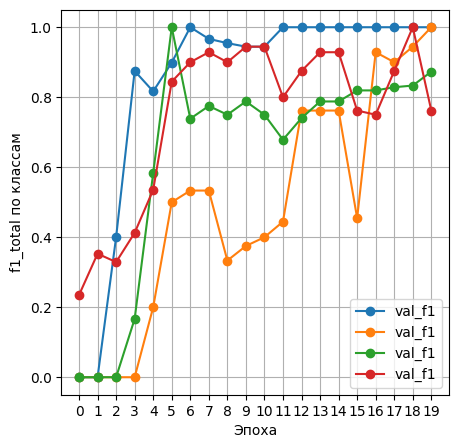

In [81]:
plt.figure(figsize=(5,5))
# plt.plot(np.arange(0, num_epochs), metrics['epoch_f1_train_list'], label='train_f1')
plt.plot(np.arange(0, num_epochs), metrics['epoch_f1_val_list'], 'o-', label='val_f1')
plt.xticks(np.arange(0, num_epochs, 1))
plt.xlabel('Эпоха')
plt.ylabel('f1_total по классам')
plt.grid()
plt.legend()
plt.show()

# Инференс

In [67]:
int_to_class_name = {class_name_to_int[key] : key for key in class_name_to_int.keys()}
int_to_class_name

{0: 'bridge_down', 1: 'bridge_up', 2: 'no_action', 3: 'train_in_out'}

In [68]:
clips_data.tail()

,label,fname,label_int
491,train_in_out,250454b3ddcbc06a.mp4,3
492,train_in_out,ccc5f58aa6de100b.mp4,3
493,train_in_out,c1023971326eb67e.mp4,3
494,train_in_out,6a810498689fad59.mp4,3
495,train_in_out,fe8f774e99637f63.mp4,3


In [71]:
index = 494
clip = read_clip(DATA_DIR.joinpath("train", clips_data['label'].loc[index]), clips_data['fname'].loc[index], transposed=True) # клип - несколько изображений

In [73]:
%%time
model_type == 'torch'

import tensorflow as tf
if model_type == 'torch':
    from torchvision.models.video import MViT_V2_S_Weights
if model_type == 'transformers':
    from transformers import VideoMAEImageProcessor


path = f'epoch_{best_epoch}.pt'
torch.set_num_threads(4)
int_to_class_name = {0: 'bridge_down', 1: 'bridge_up', 2: 'no_action', 3: 'train_in_out'}

if model_type == 'torch':
    weights = MViT_V2_S_Weights.DEFAULT
    processor = weights.transforms()
if model_type == 'transformers':
    processor = VideoMAEImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")

def predict(clip: np.ndarray):
    """Вычислить класс для этого клипа. Эта функция должна возвращать *имя* класса."""

    n_frames = 16 # сколько кадров сохранить с клипа

    if n_frames > len(clip):
        while True:
            clip = np.concatenate([clip, clip[-1][None, ...]])
            if len(clip) == n_frames:
                break
    else:
        clip = clip[0:len(clip):round(len(clip) / n_frames)]
        if len(clip) == n_frames + 1:
          clip = clip[:-1]
        if len(clip) == n_frames - 1:
          clip = np.concatenate([clip, clip[-1][None, ...]])

    if n_frames < len(clip):
      while True:
        clip = clip[:-1]
        if len(clip) == n_frames:
            break

    if model_type == 'torch':
        inputs = processor(torch.Tensor(clip)).unsqueeze(0)
        print(inputs.shape)
    if model_type == 'transformers':
        clip = [torch.Tensor(image) for image in clip]
        inputs = processor(clip, return_tensors="pt")
    model = torch.load(path, map_location=torch.device('cpu'))
    device = 'cuda'
    inputs = inputs.to(device)
    model = model.to(device)
    if model_type == 'torch':
      with torch.no_grad():
          logits = model(inputs)
          preds = tf.nn.softmax(logits.cpu().detach().numpy())
          predicted_class_idx = np.argmax(preds[0])
    if model_type == 'transformers':
      with torch.no_grad():
          outputs = model(**inputs)
          logits = outputs.logits
          predicted_class_idx = logits.argmax(-1).item()
    class_name = int_to_class_name[int(predicted_class_idx)]
    return class_name


predict(clip)

torch.Size([1, 3, 16, 224, 224])
CPU times: user 378 ms, sys: 48.8 ms, total: 427 ms
Wall time: 755 ms


'train_in_out'